In [1]:
import cv2
import mediapipe as mp
import csv
import pandas_ta as ta
import pandas as pd
import numpy as np
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter

In [2]:
video_path = 'Data/Videos/20240608_195926.mp4'
output_csv = './output'

In [3]:
## initialize pose estimator
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3, model_complexity = 2)

In [4]:
cap = cv2.VideoCapture(video_path)
res = []
while cap.isOpened():
    # read frame
    _, frame = cap.read()
    try:
         # resize the frame for portrait video
         frame = frame#[0:1440,3840-2560:3840]
         #frame = cv2.resize(frame, (1280, 720))
         # convert to RGB
         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
         
         # process the frame for pose detection
         pose_results = pose.process(frame_rgb)
         # print(pose_results.pose_landmarks)
         res.append(pose_results)
         
         # draw skeleton on the frame
         mp_drawing.draw_landmarks(frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
         # display the frame
         cv2.imshow('Output', cv2.resize(frame, (1280, 720)))
    except:
         break
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('p'):
        cv2.waitKey(-1) #wait until any key is pressed
    
    
          
cap.release()
cv2.destroyAllWindows()

In [5]:
print(res[240].pose_landmarks.landmark[32])

AttributeError: 'NoneType' object has no attribute 'landmark'

In [ ]:

df = pd.DataFrame(columns=["x", "y"])
fps = 60  # Frame rate of the video
frame_count = 0
for results in resFull:
    if results.pose_landmarks:
            # Get the landmark for the left knee.
            left_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE]
            #df = df.append({"x": left_knee.x, "y": left_knee.y}, ignore_index=True)
            # Calculate the timestamp.
            time = frame_count / fps
            # Append the coordinates and time to the DataFrame.
            df = pd.concat([df, pd.DataFrame([{'time': time, 'x': left_knee.x, 'y' : left_knee.y}])], ignore_index=True)
            #new_row = pd.DataFrame({"x": [left_knee.x], "y": [left_knee.y]})
            #df = pd.concat([df, new_row], ignore_index=True)
            frame_count +=1
df['xDeriv'] = df['x'].diff()
df["xMA"] = df['x'].rolling(window=6).mean().shift(-3)
df['xMADeriv'] = df['xMA'].diff()

C:\Users\friha\AppData\Local\Temp\ipykernel_20924\2072547219.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{'time': time, 'x': left_knee.x, 'y' : left_knee.y}])], ignore_index=True)


234


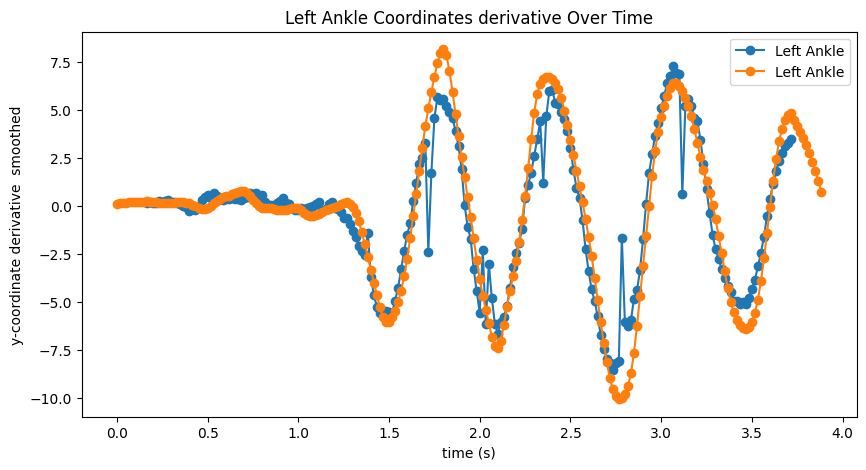

In [ ]:
# Plot the coordinates.
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['y'].rolling(window=20).mean().shift(-10).diff(), 'o-', label='Left Ankle')
df["yDeriv"] = df['y'].diff().fillna(0)
print(len(df["yDeriv"]))
df["smoothed"] = lowess(df['yDeriv'], df['time'], frac=0.095, it=1)[:, 1]

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
smoothed_left, _ = kf.smooth(df['yDeriv'].values.reshape(-1, 1))

df['smoothed_kalman'] = smoothed_left.flatten()

plt.plot(df['time'], df['smoothed'], 'o-', label='Left Ankle')
#plt.plot(df['time'], df['smoothed_kalman'], 'o-', label='Left Ankle')
plt.ylabel('y-coordinate derivative  smoothed')
plt.xlabel('time (s)') #╠y-coordinate (normalized)')
plt.title('Left Ankle Coordinates derivative Over Time')
plt.legend()
plt.show()

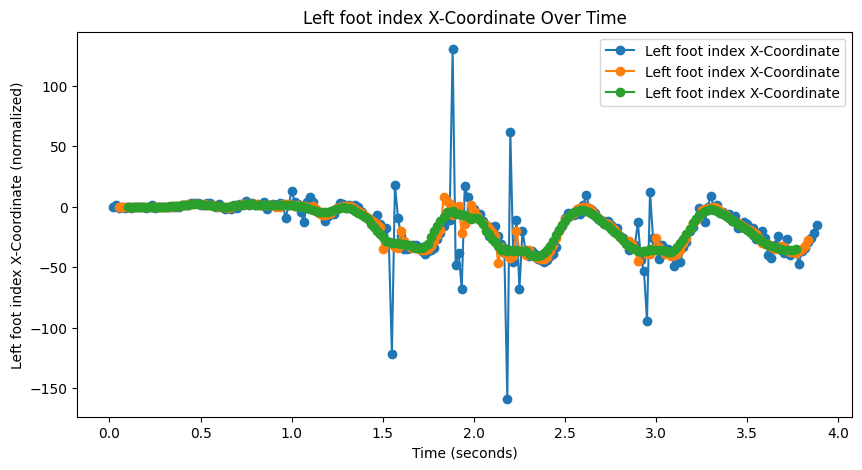

In [ ]:
# Plot the coordinates.
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['xDeriv'], 'o-', label='Left foot index X-Coordinate')
plt.plot(df['time'], df['xMADeriv'], 'o-', label='Left foot index X-Coordinate')
plt.plot(df['time'], df['xMADeriv'].rolling(window=8).mean().shift(-4), 'o-', label='Left foot index X-Coordinate')
plt.xlabel('Time (seconds)')
plt.ylabel('Left foot index X-Coordinate (normalized)')
plt.title('Left foot index X-Coordinate Over Time')
plt.legend()
plt.show()

In [6]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import deque

import numpy as np
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter

# Initialize YOLOv8 model
model = YOLO('yolov8s.pt')  # You can replace 'yolov8s.pt' with the path to your YOLOv8 model

def detect_persons(frame):
    results = model(frame, conf = 0.1)
    person_boxes = []
    
    for result in results[0].boxes:
        x1, y1, x2, y2 = map(int, result.xyxy[0])
        cls = int(result.cls)
        if cls == 0:  # Class ID 0 is for 'person'
            person_boxes.append((x1, y1, x2 - x1, y2 - y1))
    
    return person_boxes

def calculate_horizontal_velocity(current_positions, previous_positions):
    velocities = {}
    for i in current_positions:
        if i in previous_positions:
            velocities[i] = abs(current_positions[i][0] - previous_positions[i][0])
        
    return velocities



def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    #tracker = cv2.TrackerKCF_create()
    prev_positions = {}
    max_velocity = 0
    bbox_highest_velocity = None

    tracks = {}
    track_id = 0
    max_velocity_track_id = None
    frames_buffer = 6000  # Number of frames to keep for each track
    i = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Detect persons in the frame
        person_boxes = detect_persons(frame)
        

        # Track each person
        current_positions = {}
        for box in person_boxes:
            x, y, w, h = box
            center_x = x + w / 2
            center_y = y + h / 2
            #if i < 60:
                #print("hiii======")
                #print(box)
                #print("========")
            

            # Find if this is a new track or existing one
            found = False
            for trackid, (prev_center_x, prev_center_y, track) in tracks.items():
                #print("false")
                #print(prev_center_x, prev_center_y, trackid)
                if abs(center_x - prev_center_x) < w and abs(center_y - prev_center_y) < h:
                    #print("changed in track id ", trackid, )
                    found = True
                    current_positions[trackid] = (center_x, box)
                    tracks[trackid] = (center_x, center_y, track + [[x,y,w,h]])
                    break

            if not found:
                temp = list([[x,y,w,h]])
                tracks[track_id] = (center_x, center_y, temp)#deque(maxlen=frames_buffer))
                current_positions[track_id] = (center_x, box)
                #print("track id ", track_id)
                track_id += 1
                

        velocities = calculate_horizontal_velocity(current_positions, prev_positions)
        for trackid, velocity in velocities.items():
            if velocity > max_velocity:
                #print("happened ", velocity, " track id  ", trackid)
                max_velocity = velocity
                max_velocity_track_id = trackid
                bbox_highest_velocity = current_positions[trackid][1]

        prev_positions = current_positions
        

            
        i += 1

        # Draw bounding boxes and track IDs
        for track_id, (center_x, center_y, track) in tracks.items():
            if track_id in current_positions:
                box = current_positions[track_id][1]
                x, y, w, h = box
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                cv2.putText(frame, f"ID: {track_id}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        cv2.imshow('Frame', cv2.resize(frame, (1280, 720)))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    return bbox_highest_velocity, max_velocity_track_id, tracks

# Example usage
#video_path = "path_to_your_video.mp4"
#bbox, id, tracks = process_video(video_path)
#print("Bounding box of the person with highest horizontal velocity:", bbox)


def calculate_max_horizontal_velocity(dataset):
    if not dataset:
        return None

    # Extract all x-coordinates
    x_coords = [box[0] for box in dataset]

    # Calculate max and min x-coordinates
    max_x = max(x_coords)
    min_x = min(x_coords)

    # Calculate horizontal velocity
    horizontal_velocity = max_x - min_x

    # Find the bounding box with the max x-coordinate
    max_x_box = next(box for box in dataset if box[0] == max_x)

    return max_x_box, horizontal_velocity
def find_max_velocity(velocity_dict):
    if not velocity_dict:
        return None

    # Find the ID with the maximum velocity
    max_id = max(velocity_dict, key=velocity_dict.get)
    max_velocity = velocity_dict[max_id]

    return max_id, max_velocity
# velocities = {}
# for i in tracks:
#     box, v = calculate_max_horizontal_velocity(tracks[i][2])
#     velocities[i] = v
    
# max_velocity_id, max_velocity = find_max_velocity(velocities)
# print(max_velocity_id, max_velocity)
# print(tracks.keys())
# print(tracks[max_velocity_id][2], max_velocity)

import cv2
import mediapipe as mp
import copy

# Initialize MediaPipe Pose and drawing modules
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Function to convert normalized coordinates to pixel coordinates
def normalized_to_pixel_coordinates(normalized_x, normalized_y, image_width, image_height):
    if 0 <= normalized_x <= 1 and 0 <= normalized_y <= 1:
        x_px = min(int(normalized_x * image_width), image_width - 1)
        y_px = min(int(normalized_y * image_height), image_height - 1)
        return x_px, y_px
    else:
        return None

# Example video path


# Load your video

res = []
resFull = []  # List to store full frame pose results


pose = mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3, model_complexity = 2)

    

def getPoseEstimation(tracks, max_velocity_id):
    
    
    res = []
    resFull = []  # List to store full frame pose results
    
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    pose = mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3, model_complexity = 2)
    
    cap = cv2.VideoCapture(video_path)
    index = 0
# Initialize pose estimation
    with pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if (not ret):

                break
            
            try:
                print("hi")
                # Define the crop region dynamically based on tracks[max_velocity_id]
                x_start = tracks[max_velocity_id][2][index][0] - 300

                x_end = tracks[max_velocity_id][2][index][0] + tracks[max_velocity_id][2][index][2] + 200
                y_start = tracks[max_velocity_id][2][index][1] - 200
                y_end = tracks[max_velocity_id][2][index][1] + tracks[max_velocity_id][2][index][3] + 200
                print('yo')
                # cropping_digits = [x_start, x_end, y_start, y_end]
                # print(cropping_digits)
                # for i in range(len(cropping_digits)):
                #     if i < 2 :
                #         if cropping_digits[i] > frame.shape[1]:
                #             cropping_digits[i] = frame.shape[1]
                #         if cropping_digits[i] < 0:
                #             cropping_digits[i] = 0
                #     if i >= 2 :
                #         if cropping_digits[i] > frame.shape[0]:
                #             cropping_digits[i] = frame.shape[0]
                #         if cropping_digits[i] < 0:
                #             cropping_digits[i] = 0    
                # x_strart, x_end, y_start, y_end = cropping_digits
                print("here issue x) ",x_start, x_end, y_start, y_end)
                #if index >= 81:
                    #print("before switch ", x_start)
                    #x_start = 0
                if x_start <= 0:
                    x_start = 0
                if y_start <= 0:
                    y_start = 0
                if x_end >= frame.shape[1]:
                    x_end = frame.shape[1]
                if y_end >= frame.shape[0]:
                    y_end = frame.shape[0]
                if x_start >= frame.shape[1]:
                    x_start = frame.shape[1]
                if y_start >= frame.shape[0]:
                    y_start = frame.shape[0]
                if x_end <= 0:
                    x_end = 0
                if y_end <= 0:
                    y_end = 0

                #x_start,x_end,y_start,y_end = [0,3840,0,2160]
                # Extract the cropped frame

                cropped_frame = frame[y_start:y_end, x_start:x_end]
                print("cropped shape", cropped_frame.shape)
                print("working", index)
                print(x_start, x_end, y_start, y_end)
                # Convert to RGB
                frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
                print("working after", index)
                # Process the frame for pose detection
                pose_results = pose.process(frame_rgb)
                res.append(pose_results)


                # Draw landmarks on the cropped frame for visualization
                mp_drawing.draw_landmarks(frame_rgb, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                # Replace the region in the full frame with the annotated cropped frame
                frame[y_start:y_end, x_start:x_end] = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)

                if pose_results.pose_landmarks:
                    # Deep copy the pose results to convert landmarks to full frame coordinates
                    pose_results_full = copy.deepcopy(pose_results)

                    for i, landmark in enumerate(pose_results.pose_landmarks.landmark):
                        # Convert normalized coordinates to pixel coordinates based on the cropped frame size
                        pixel_coords = normalized_to_pixel_coordinates(
                            landmark.x, landmark.y,
                            cropped_frame.shape[1], cropped_frame.shape[0]
                        )

                        if pixel_coords:
                            cx, cy = pixel_coords

                            # Adjust the coordinates to the full frame
                            full_frame_x = x_start + cx
                            full_frame_y = y_start + cy

                            # Update the full frame landmarks in pose_results_full
                            pose_results_full.pose_landmarks.landmark[i].x = full_frame_x #/ frame.shape[1]
                            pose_results_full.pose_landmarks.landmark[i].y = full_frame_y #/ frame.shape[0]
                            pose_results_full.pose_landmarks.landmark[i].z = landmark.z  # z-coordinate remains unchanged

                            # Draw the landmark on the full frame
                            #cv2.circle(frame, (full_frame_x, full_frame_y), 5, (0, 255, 0), -1)

                    # Append the full frame pose results to the resFull list
                    resFull.append(pose_results_full)


                index += 1

                # Display the frame
                cv2.imshow('Output', cv2.resize(frame, (1280, 720)))

            except Exception as e:
                print(f"An error occurred: {e}")
                break
            
            key = cv2.waitKey(1)
            if key == ord('q'):
                break
            if key == ord('p'):
                cv2.waitKey(-1)  # Wait until any key is pressed

    cap.release()
    cv2.destroyAllWindows()
    return res, resFull
#getPoseEstimation()

def platesPosition(plateDetector):
    plateDetectorr = copy.deepcopy(plateDetector)
    
    defPos = ["Bottom-right",
              "Top-right",
            "Midpoint",
            "Top-left",
            "Bottom-left",]
    
 
    platesPos = []
    
    def getmaxX(plateDetectorr):
        max = 0
        maxId = None
        for bbox_set in plateDetectorr:
            if bbox_set['bbox'][0] >= max:
                max = bbox_set['bbox'][0]
                maxId = bbox_set['id']
        return maxId
    
    i = 0
    
    for pos in defPos:
        for bbox_set in plateDetectorr:
            if bbox_set['id'] == getmaxX(plateDetectorr):
                platesPos.append([{"id": bbox_set['id'], "position": pos, "bbox": bbox_set['bbox']}])
                plateDetectorr.remove(bbox_set)
            i +=1
              # Assuming ids are unique, we can stop searching after finding the match
        print(plateDetectorr)
    return platesPos   


from pipleline_classes.PlatessDetection import PlatesDetection#, My
from g9 import detee
import sys
import os

# sys.path.append(os.path.abspath('subfolder'))

# #My()

# plateDetector = detee(video_path)#PlatesDetection()
# platesPositions = platesPosition(plateDetector)
# print(plateDetector)
# print(platesPositions)
from pipleline_classes.PlatessDetection import PlatesDetection#, My
from g9 import detee
import sys
import os

#sys.path.append(os.path.abspath('subfolder'))

#My()

#plateDetector = detee(video_path)#PlatesDetection()
#platesPositions = platesPosition(plateDetector)
#print(plateDetector)
#plateDetector.pp()
#plateDetector.detectPlates("Data\Pictures\VideoCapture_20240607-183522.jpg")

#print(platesPositions)
def get_calibration_points(video_path):
    from g9 import detee
    plateDetector = detee(video_path)
    platesPositions = platesPosition(plateDetector)
    def get_xybbox_by_pos(data_structure, pos_to_get):
        for item in data_structure:
            if item[0]['position'] == pos_to_get:
                cx = item[0]["bbox"][0] + item[0]["bbox"][2] / 2
                cy = item[0]["bbox"][1] + item[0]["bbox"][3] / 2
                return [cx, cy]
        return None  # If id is not found  
    
    
    # Real-world coordinates in meters (example for a 10m x 1.22m segment)
    real_world_points = np.array([
        [0, 0, 0],     # Top-left cone
        [10, 0, 0],    # Top-right cone
        [10, 1.22, 0], # Bottom-right cone
        [0, 1.22, 0],  # Bottom-left cone
        [5, 0, 0],     # Midpoint of the top side
    ], dtype=np.float32)

    # Image coordinates (manually detected or using an image processing technique)
    image_points = np.array([
        get_xybbox_by_pos(platesPositions, "Top-left"),  # Top-left cone (example pixel coordinates)
        get_xybbox_by_pos(platesPositions, "Top-right"), # Top-right cone (example pixel coordinates)
        get_xybbox_by_pos(platesPositions, "Bottom-right"), # Bottom-right cone (example pixel coordinates)
        get_xybbox_by_pos(platesPositions, "Bottom-left"),  # Bottom-left cone (example pixel coordinates)
        get_xybbox_by_pos(platesPositions, "Midpoint")  # Midpoint of the top side
    ], dtype=np.float32)

    
    return real_world_points, image_points

#get_calibration_points()
#platesPositions[0][0]
import cv2

def calibrate_camera(real_world_points, image_points, image_size):
    # Compute homography matrix
    H, _ = cv2.findHomography(image_points, real_world_points[:, :2])
    return H

def detect_hip_joint(ress):
    # Dummy function: replace with actual detection logic
    # Returns coordinates of the hip joint in the image
    # e.g., using MediaPipe Pose estimation
    x = ress.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x
    y = 1060
    return (x, y)

def apply_homography(H, point):
    point = np.array([point[0], point[1], 1.0])
    world_point = np.dot(H, point)
    world_point /= world_point[2]
    return world_point[:2]

def calculate_speed(positions, fps):
    velocities = []
    for i in range(1, len(positions)):
        dist = np.linalg.norm(np.array(positions[i]) - np.array(positions[i-1]))
        time = 1 / fps
        velocity = dist / time
        velocities.append(velocity)
    return velocities

def process_instant_velocity( H, fps, resFull):

    positions = []

    for ress in  resFull:
        if not ress.pose_landmarks:
            break

        # Detect the athlete's hip joint in the frame
        hip_joint = detect_hip_joint(ress)
        if hip_joint:
            # Convert the detected position to real-world coordinates
            real_world_pos = apply_homography(H, hip_joint)
            positions.append(real_world_pos)

    

    # Calculate the athlete's speed
    velocities = calculate_speed(positions, fps)
    return velocities

def moving_average(arr, window_size):
    # Define an output array to store the moving averages
    moving_averages = np.zeros(len(arr) - window_size + 1)
    
    # Iterate over the array to compute the moving averages
    for i in range(len(arr) - window_size + 1):
        # Extract the window of values
        window = arr[i:i+window_size]
        # Calculate the average of the window
        moving_averages[i] = np.mean(window)
    
    return moving_averages
def Metrics( resFull, video_path):
    if __name__ == "__main__":
        real_world_points, image_points = get_calibration_points(video_path)
        image_size = (3840, 2160)  # Example image size, replace with actual
        H = calibrate_camera(real_world_points, image_points, image_size)
        print("matrix: ", H)
        #video_path = 'athlete_video.mp4'
        fps = 60  # Assuming 60 frames per second
        velocities = process_instant_velocity( H, fps, resFull)
        print("velocities: ", velocities)
        import matplotlib.pyplot as plt
        time_steps = np.arange(len(velocities)) / fps
        #lowess(df['yDeriv'], df['time'], frac=0.095, it=1)[:, 1]
        df = pd.DataFrame({"velocity" : velocities, "time_steps": time_steps})
        #df["time_steps"] = np.arange(len(velocities)) / fps
        print(df)
        dfsmooth = pd.DataFrame(lowess(df['velocity'], df['time_steps'], frac=0.095, it=1), columns=['time_steps', 'velocity'])#[:, 1]
        print(dfsmooth)

        plt.plot(time_steps, velocities)
        #plt.plot(moving_average(time_steps, 20), moving_average(velocities, 20))
        #plt.plot(time_steps, dfsmooth['velocity'])
        plt.xlabel('Time (seconds)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Athlete Velocity Over Time')
        plt.show()
        print(dfsmooth)
        return dfsmooth
#Metrics(resFull)

import cv2
import mediapipe as mp
import copy
from pipleline_classes.PlatessDetection import PlatesDetection#, My
from g9 import detee
import sys
import os

video_path = 'Data/Videos/20240608_195926.mp4'
def main(video_path):
    video_path = video_path
    model = YOLO('yolov8s.pt')
    bbox, id, tracks = process_video(video_path)
    print("tracks: ", tracks)
    velocities = {}
    for i in tracks:
        box, v = calculate_max_horizontal_velocity(tracks[i][2])
        velocities[i] = v

    max_velocity_id, max_velocity = find_max_velocity(velocities)
    print(max_velocity_id, max_velocity)
    print(tracks.keys())
    print(tracks[max_velocity_id][2], max_velocity)
    # Initialize MediaPipe Pose and drawing modules

    res,resFull = getPoseEstimation(tracks, max_velocity_id)
    print('resFull', resFull)
    sys.path.append(os.path.abspath('subfolder'))


    plateDetector = detee(video_path)#PlatesDetection()
    platesPositions = platesPosition(plateDetector)
    print(plateDetector)
    print(platesPositions)
    
    return Metrics(resFull, video_path)



0: 384x640 1 person, 5 sports balls, 218.6ms
Speed: 0.0ms preprocess, 218.6ms inference, 815.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 278.4ms
Speed: 42.3ms preprocess, 278.4ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 184.9ms
Speed: 6.0ms preprocess, 184.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 201.3ms
Speed: 3.0ms preprocess, 201.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 189.1ms
Speed: 3.7ms preprocess, 189.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 181.2ms
Speed: 3.7ms preprocess, 181.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 178.8ms
Speed: 11.7ms preprocess, 178.8ms inference, 0.0ms postprocess per image at shape (1, 3

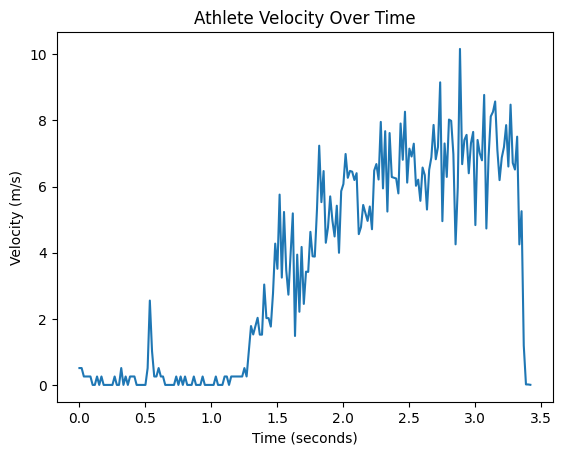

     time_steps  velocity
0      0.000000  0.412684
1      0.016667  0.374532
2      0.033333  0.337478
3      0.050000  0.301331
4      0.066667  0.265904
..          ...       ...
201    3.350000  2.932552
202    3.366667  2.308940
203    3.383333  1.674679
204    3.400000  1.028088
205    3.416667  0.368975

[206 rows x 2 columns]


,time_steps,velocity
0,0.000000,0.412684
1,0.016667,0.374532
2,0.033333,0.337478
3,0.050000,0.301331
4,0.066667,0.265904
...,...,...
201,3.350000,2.932552
202,3.366667,2.308940
203,3.383333,1.674679
204,3.400000,1.028088


In [9]:
video_path = 'Data/Videos/20240608_195926.mp4'
main(video_path)


0: 384x640 1 person, 5 sports balls, 194.4ms
Speed: 0.0ms preprocess, 194.4ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 199.1ms
Speed: 8.6ms preprocess, 199.1ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 202.9ms
Speed: 0.0ms preprocess, 202.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 218.6ms
Speed: 2.2ms preprocess, 218.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 176.9ms
Speed: 0.0ms preprocess, 176.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 184.3ms
Speed: 3.4ms preprocess, 184.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 177.2ms
Speed: 0.0ms preprocess, 177.2ms inference, 0.0ms postprocess per image at shape (1, 3, 38

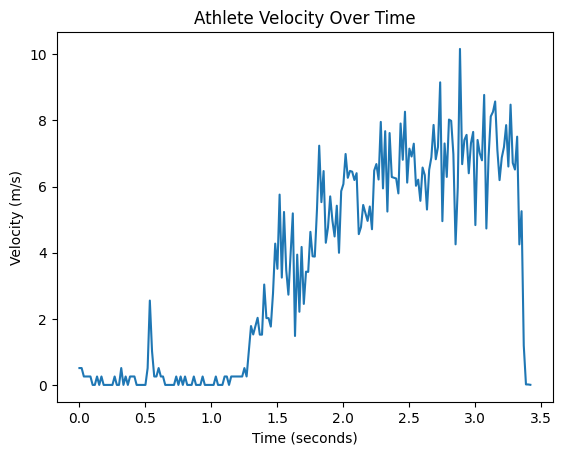

     time_steps  velocity
0      0.000000  0.412684
1      0.016667  0.374532
2      0.033333  0.337478
3      0.050000  0.301331
4      0.066667  0.265904
..          ...       ...
201    3.350000  2.932552
202    3.366667  2.308940
203    3.383333  1.674679
204    3.400000  1.028088
205    3.416667  0.368975

[206 rows x 2 columns]


,time_steps,velocity
0,0.000000,0.412684
1,0.016667,0.374532
2,0.033333,0.337478
3,0.050000,0.301331
4,0.066667,0.265904
...,...,...
201,3.350000,2.932552
202,3.366667,2.308940
203,3.383333,1.674679
204,3.400000,1.028088


In [ ]:
import cv2
import mediapipe as mp
import copy
from pipleline_classes.PlatessDetection import PlatesDetection#, My
from g9 import detee
import sys
import os

video_path = 'Data/Videos/20240608_195926.mp4'
def main(video_path):
    video_path = video_path
    model = YOLO('yolov8s.pt')
    bbox, id, tracks = process_video(video_path)
    print("tracks: ", tracks)
    velocities = {}
    for i in tracks:
        box, v = calculate_max_horizontal_velocity(tracks[i][2])
        velocities[i] = v

    max_velocity_id, max_velocity = find_max_velocity(velocities)
    print(max_velocity_id, max_velocity)
    print(tracks.keys())
    print(tracks[max_velocity_id][2], max_velocity)
    # Initialize MediaPipe Pose and drawing modules

    res,resFull = getPoseEstimation(tracks, max_velocity_id)
    print('resFull', resFull)
    sys.path.append(os.path.abspath('subfolder'))


    plateDetector = detee(video_path)#PlatesDetection()
    platesPositions = platesPosition(plateDetector)
    print(plateDetector)
    print(platesPositions)
    
    return Metrics(resFull, video_path)

    
    
main(video_path)
    

In [1]:
from fastapi import FastAPI
from pydantic import BaseModel
import fastapi
import uvicorn
import os
import signal
from fastapi.middleware.cors import CORSMiddleware
from fastapi import FastAPI, UploadFile, File
from typing import List
from finalpipe2 import main
from pathlib import Path


app = FastAPI()

origins = [
    "*",
]

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)


# Define your AI model function here
def my_ai_model(data):
    # Dummy model function, replace with your actual model inference code
    return {"result": "AI model output based on input data"}

# Define a request body model using Pydantic
class InputData(BaseModel):
    input_text: str


# Add a shutdown event
def shutdown():
    os.kill(os.getpid(), signal.SIGTERM)
    return fastapi.Response(status_code=200, content='Server shutting down...')

def hello():
    return fastapi.Response(status_code=200, content='Hello, world!')

@app.on_event('shutdown')
def on_shutdown():
    print('Server shutting down...')
video_path = 'Data/Videos/20240608_195926.mp4'
def predictt():
    res = main(video_path)
    return res

app.add_api_route('/hello', hello, methods=['GET'])
app.add_api_route('/shutdown', shutdown, methods=['GET'])
app.add_api_route('/predictt', predictt, methods=['GET'])

# Define a route that uses the AI model
@app.post("/predict")
async def predict(data: InputData):
    result = my_ai_model(data.input_text)
    return result

# Define the directory to save uploaded files
UPLOAD_DIR = Path("uploaded_videos")
UPLOAD_DIR.mkdir(parents=True, exist_ok=True)


@app.post("/process")
async def process_video(file: UploadFile = File(...)):
    # Construct the file path
    file_path = UPLOAD_DIR / file.filename

    # Save the file
    with open(file_path, "wb") as buffer:
        buffer.write(await file.read())

    # Process the video file
    res =  main(str(file_path))
    print(res)

    # Return the result of the processing and the file info
    return {"filename": file.filename, "content_type": file.content_type, "file_path": str(file_path), "processing_result": res}

C:\Users\friha\AppData\Local\Temp\ipykernel_19896\2663339546.py:47: DeprecationWarning: 
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
  @app.on_event('shutdown')


INFO:     Started server process [19896]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)



0: 384x640 5 sports balls, 242.6ms
Speed: 5.7ms preprocess, 242.6ms inference, 960.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 251.4ms
Speed: 4.0ms preprocess, 251.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 sports balls, 311.0ms
Speed: 0.0ms preprocess, 311.0ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 5 sports balls, 301.8ms
Speed: 5.2ms preprocess, 301.8ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 332.8ms
Speed: 6.0ms preprocess, 332.8ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 346.5ms
Speed: 5.0ms preprocess, 346.5ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5 sports balls, 349.7ms
Speed: 7.1ms preprocess, 349.7ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x6

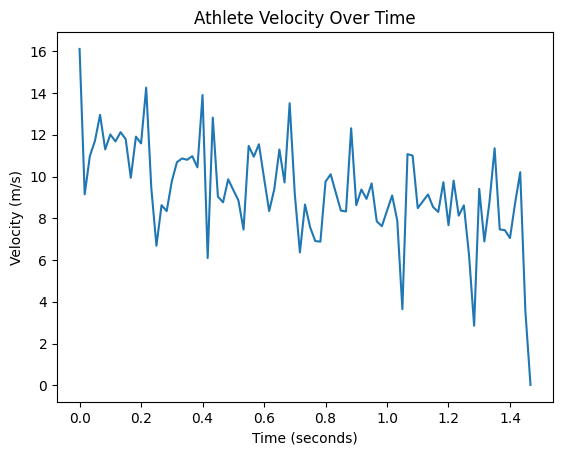

[{"velocity":16.1113835068,"time_steps":0.0},{"velocity":9.146095765,"time_steps":0.0166666667},{"velocity":10.9724331732,"time_steps":0.0333333333},{"velocity":11.7069141823,"time_steps":0.05},{"velocity":12.9546880382,"time_steps":0.0666666667},{"velocity":11.2973922184,"time_steps":0.0833333333},{"velocity":12.0127842164,"time_steps":0.1},{"velocity":11.67947917,"time_steps":0.1166666667},{"velocity":12.1230816133,"time_steps":0.1333333333},{"velocity":11.7911522961,"time_steps":0.15},{"velocity":9.9400171134,"time_steps":0.1666666667},{"velocity":11.9103123464,"time_steps":0.1833333333},{"velocity":11.5848464095,"time_steps":0.2},{"velocity":14.257231741,"time_steps":0.2166666667},{"velocity":9.4451819073,"time_steps":0.2333333333},{"velocity":6.6822899174,"time_steps":0.25},{"velocity":8.6269003166,"time_steps":0.2666666667},{"velocity":8.3424654775,"time_steps":0.2833333333},{"velocity":9.7671220945,"time_steps":0.3},{"velocity":10.684926823,"time_steps":0.3166666667},{"velocity"

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 408, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 84, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Python311\Lib\site-packages\starlette\applications.py", line 119, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Python311\Lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise exc
  File "c:\Python311\Lib\site-packages\starlette\middleware\errors.py", line 164, in __call__
    await self.app(scope, recei

In [ ]:
import asyncio
import uvicorn


if __name__ == "__main__":
    
    config = uvicorn.Config(app, host="0.0.0.0", port=8000)
    server = uvicorn.Server(config)
    loop = asyncio.get_running_loop()
    loop.create_task(server.serve())